In [20]:
import pandas as pd
import os, gc, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import roc_curve,auc, precision_recall_curve
from sklearn.model_selection import KFold
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score


sys.path.append("../source/")
from helper_functions import *


In [2]:
useID = False

dl = DataLoader()
df_tr = dl.load_csv("train_transaction.csv")
# df_tr_test = dl.load_csv("test_transaction.csv")

if useID:
    dl.transaction = False
    df_id = dl.load_csv("train_identity.csv")
    df_id_test = dl.load_csv("test_identity.csv")

    df_train = df_tr.merge(df_id, how='left', left_index=True, right_index=True)

    fix = {o:n for o, n in zip(df_id_test.columns, df_id.columns)}
    df_id.rename(columns=fix, inplace=True)
   # df_test = df_tr_test.merge(df_id, how='left', left_index=True, right_index=True)

    del df_id, df_id_test, df_train #, df_tr_test

else:
    df_train = df_tr
    #df_test = df_tr_test
    del df_tr#, df_tr_test


# df_train['isTrain'] = 1
# df_test['isTrain'] = 0

# df = pd.concat([df_train, df_test])
gc.collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 395 entries, TransactionID to TransactionDay
dtypes: bool(9), float32(377), int16(1), int32(2), int8(6)
memory usage: 863.4 MB


20

In [4]:
df = df_train
v_columns = [v for v in df.columns if v.startswith("V")]
df = remove_correlated_columns(df, v_columns)


In [7]:
df['uid'] = df["card1"].astype(str)+'_'+df["addr1"].astype(str)+'_'+df["D1"].astype(str)
# df_train = df_train.drop(columns=["TransactionID"])

In [5]:
# Sort by TransactionTD
df = df.sort_values('TransactionDT').reset_index(drop=True)

# Create an empty column
df['IsDuplicateInWindow'] = 1

# Get numpy arrays for faster operations
tds = df['TransactionDT'].values
amts = df['TransactionAmt'].values

# Use searchsorted to find window ranges
for i in range(len(df)):
    lower = tds[i] - 500
    upper = tds[i] + 500

    # Find indices where TD is within ±100
    start = np.searchsorted(tds, lower, side='left')
    end = np.searchsorted(tds, upper, side='right')

    # Slice the relevant window and check for other matching TransactionAmt
    window_amts = amts[start:end]
    match_count = np.sum(window_amts == amts[i])

    df.at[i, 'IsDuplicateInWindow'] = match_count


In [8]:
columns_to_encode = [v for v in df.columns if v.startswith("V")]
columns_to_encode.append("TransactionAmt")
columns_to_encode.append("TransactionDT")
d_columns = [v for v in df.columns if v.startswith("D")]
columns_to_encode += d_columns
df = encode_AG(df, 'uid', columns_to_encode)

In [53]:
df['uid'].nunique()

589923

In [50]:
for uid in df['uid'].values:
    if len(df[df['uid']==uid]) > 1:
        d = df[df['uid']==uid]
        break

In [52]:
d['uid']

722       12839_264.0_-482.8387
151813    12839_264.0_-482.8387
Name: uid, dtype: object

In [46]:
d = df[df['uid']=='12695_325.0_0.0']
d = d.sort_values(by="TransactionDT")
consecutive_fraud = 0
for i in range(len(d)):
    if d.iloc[i]['isFraud'] == 1:
        consecutive_fraud += 1
    else:
        print(consecutive_fraud)

In [ ]:
# Fill NaN for V columns with mean values
v_columns = [str(col) for col in df.columns if str(col).startswith("V")]
df = df.fillna(df[v_columns].mean())


In [83]:
from sklearn.model_selection import train_test_split

y = df["isFraud"]
X = df.drop(columns=["isFraud", "uid"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [90]:
params = {"device":"cuda", "objective":"binary:logistic",
                "eval_metric":"logloss",
                'learning_rate': 0.12,
                'max_depth': 12, }

dtrain = xgb.DMatrix(X, label=y) 
dval = xgb.DMatrix(X_test, label=y_test)

model = xgb.train(params, dtrain, num_boost_round=150)
importance = model.get_score(importance_type='gain')

y_prob = model.predict(dval)


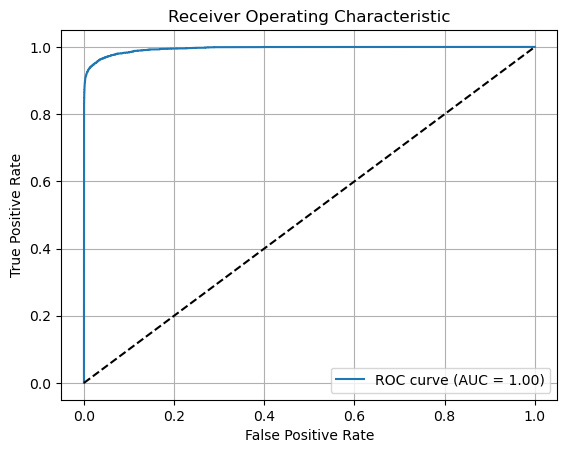

In [91]:
 
# Compute ROC curve and AUC
fpr, tpr, threshold = roc_curve(y_test.astype(int).values, y_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Best F1: 0.9198 at threshold: 0.2427
auc 0.9558055995589474


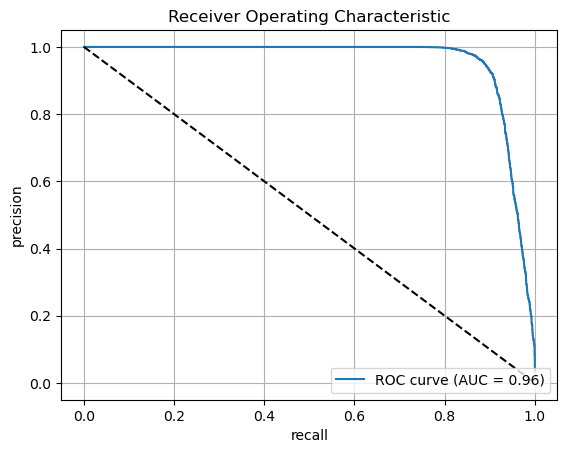

In [92]:
 
# Compute ROC curve and AUC
precision, recall, threshold = precision_recall_curve(y_test.astype(int).values, y_prob)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]

best_index = np.argmax(f1_scores)
best_threshold = threshold[best_index]

roc_auc = auc(recall, precision)
print(f"Best F1: {f1_scores[best_index]:.4f} at threshold: {best_threshold:.4f}")
print("auc", roc_auc)
plt.figure()
plt.plot(recall,precision, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [1, 0], 'k--')  # Diagonal line
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

y_pred = y_prob > best_threshold
y_pred = (y_pred == 1).astype(int)


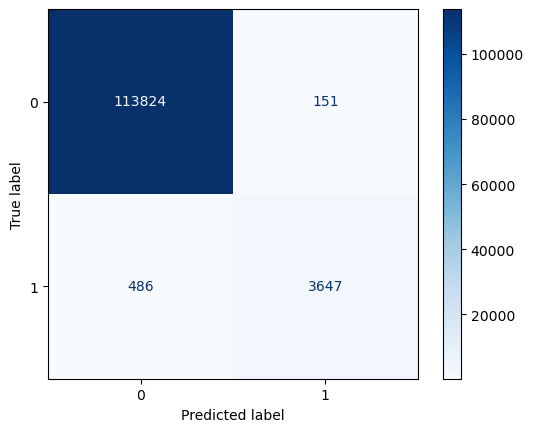

In [93]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

In [43]:
# Isolation doesn't work, because individual instances are not isFraud! 
# we need to try to group uinque cards together and make aggregate features
# Then predict which cards are outliers


clf = IsolationForest().fit(X)
pred = clf.predict(X_test)

In [44]:
pred = (pred == -1).astype(int) # -1 is an outlier, but in our data 1 == isFraud


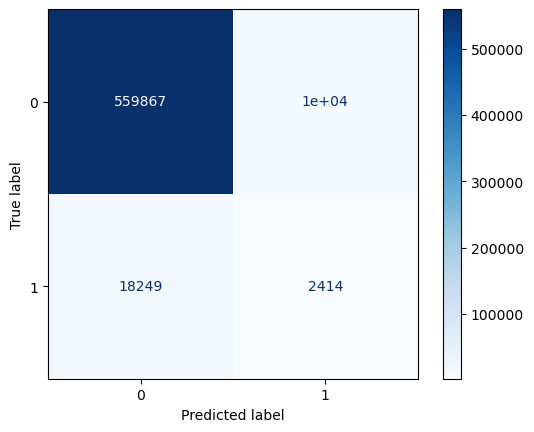

In [ ]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

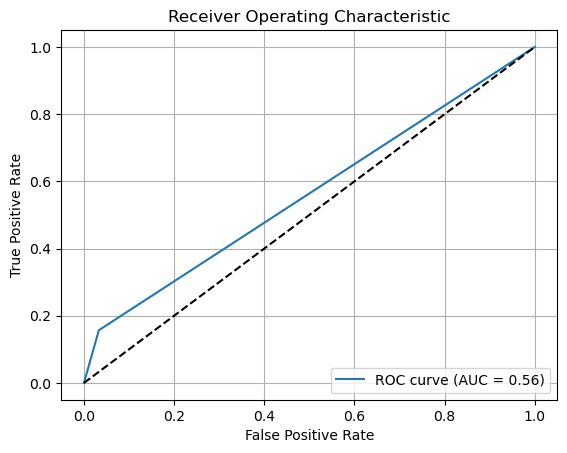

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()